In [1]:
import rpy2.ipython
rpy2.ipython.load_ipython_extension(get_ipython())

In [2]:
%%R
library(recount3) 
library(edgeR)
library(SummarizedExperiment)
library(hipathia) 

R[write to console]: Loading required package: SummarizedExperiment

R[write to console]: Loading required package: MatrixGenerics

R[write to console]: Loading required package: matrixStats

R[write to console]: 
Attaching package: ‘MatrixGenerics’


R[write to console]: The following objects are masked from ‘package:matrixStats’:

    colAlls, colAnyNAs, colAnys, colAvgsPerRowSet, colCollapse,
    colCounts, colCummaxs, colCummins, colCumprods, colCumsums,
    colDiffs, colIQRDiffs, colIQRs, colLogSumExps, colMadDiffs,
    colMads, colMaxs, colMeans2, colMedians, colMins, colOrderStats,
    colProds, colQuantiles, colRanges, colRanks, colSdDiffs, colSds,
    colSums2, colTabulates, colVarDiffs, colVars, colWeightedMads,
    colWeightedMeans, colWeightedMedians, colWeightedSds,
    colWeightedVars, rowAlls, rowAnyNAs, rowAnys, rowAvgsPerColSet,
    rowCollapse, rowCounts, rowCummaxs, rowCummins, rowCumprods,
    rowCumsums, rowDiffs, rowIQRDiffs, rowIQRs, rowLogSumExps,
    rowMadDiff

In [3]:
%%R
####-- BLOOD
gtex_blood <- subset(available_projects(), file_source == "gtex" & 
                           project =="BLOOD")
rseBLOOD <- create_rse(gtex_blood)
rseBLOOD <- rseBLOOD[, rseBLOOD$gtex.smtsd == "Whole Blood" & rseBLOOD$gtex.smafrze == "RNASEQ"]

####--- OVARY
#gtex_ovar <- subset(available_projects(), file_source == "gtex" & 
#                         project =="OVARY")
#rseOVAR <- create_rse(gtex_ovar)
###--- UTERUS
#gtex_uter <- subset(available_projects(), file_source == "gtex" & 
#                          project =="UTERUS")
#rseUTER <- create_rse(gtex_uter)
###--- THYROIDES
gtex_thyr <- subset(available_projects(), file_source == "gtex" & 
                          project =="THYROID")
rseTHYR<- create_rse(gtex_thyr)
rseTHYR <- rseTHYR[, rseTHYR$gtex.smafrze == "RNASEQ"]
#rseTHYR<- create_rse(gtex_thyr)
    
##--- COOMBINADO
rse <- cbind(rseBLOOD, rseTHYR)
#rse2 <- cbind(rseBLOOD, rseOVAR)

R[write to console]: 2025-10-25 10:54:34.316306 caching file sra.recount_project.MD.gz.

R[write to console]: 2025-10-25 10:54:35.484525 caching file gtex.recount_project.MD.gz.

R[write to console]: 2025-10-25 10:54:36.569926 caching file tcga.recount_project.MD.gz.

R[write to console]: 2025-10-25 10:54:40.416324 downloading and reading the metadata.

R[write to console]: 2025-10-25 10:54:45.204352 caching file gtex.gtex.BLOOD.MD.gz.

R[write to console]: 2025-10-25 10:54:50.23013 caching file gtex.recount_project.BLOOD.MD.gz.

R[write to console]: 2025-10-25 10:54:55.147251 caching file gtex.recount_qc.BLOOD.MD.gz.

R[write to console]: 2025-10-25 10:54:59.898241 caching file gtex.recount_seq_qc.BLOOD.MD.gz.

R[write to console]: 2025-10-25 10:55:03.285229 downloading and reading the feature information.

R[write to console]: 2025-10-25 10:55:08.241091 caching file human.gene_sums.G026.gtf.gz.

R[write to console]: 2025-10-25 10:55:08.735456 downloading and reading the counts: 1048 

In [4]:
%%R
## Obtengo por separado un array con los conteso crudos de RNA-seq y los 
## datos clínicos y experimentales en metadata
counts <- assay(rse, "raw_counts")  #Matriz de conteos crudos
metadata <- colData(rse)            #df de datos clínicos y experimentales

In [5]:
%%R
### 2 - PRE-FILTRADOO
keep <- rowSums(counts > 0) >= 5  # Genes expresados en ≥5 muestras
counts <- counts[keep, ] #De 63856 genes a 55424 genes


In [6]:
%%R
## 3 - NORMALIZACIÓN TMM EN DATOS CRUDOS 

    # Normalización TMM = Trimmed Mean of M-values:
    # método para corregir diferencias en la profundidad de secuenciación y 
    # en la composición global del RNA entre muestras.
    # Conversión counts crudos a CPM (Counts Per Million),
    # usando tamaños de librería ajustados con factores de normalización TMM 
    # (calcula lib.size * norm.factors)
dge <- DGEList(counts = counts) # clase DGEList (Differential Gene Expression List)
dge_norm <- cpm(dge, 
                    normalized.lib.sizes = TRUE, 
                    log = FALSE)                              
                     
dge_normalized <- log2(dge_norm + 1) # transformación log2 para obtener valores continuos comparables 

In [7]:
%%R
### 4 - CAMBIO DE ENSEMBL A ENTREZ (Hipathia)
data_entrez <- translate_data(dge_normalized, "hsa")
      # translated ids = 23736 (0.43) 
      # untranslated ids = 31688 (0.57) 
      # multihit ids = 181 (0.0033) 
    ## De los 55424 genes por Ensembl, se reconocen 23638 con id Entrez en Hipathia
table(is.na(rownames(data_entrez)))
    # IMPORTANTE: que no existan filas con id no reconocidos por Hipathia

R[write to console]: snapshotDate(): 2023-10-23



translated ids = 23716 (0.43) 
untranslated ids = 31685 (0.57) 
multihit ids = 184 (0.0033) 

FALSE 
23617 


In [8]:
%%R
### 5 - NORMALIZACION a [0,1] (Hipathia)
data_entrez_norm <- normalize_data(data_entrez)
    
### 6 - OBJETO FINAL PARA HIPATHIA SummarizedEperiment
data_info <- SummarizedExperiment(
    assays = list(counts = data_entrez_norm), #counts normalizados
     colData = DataFrame(
        tissue = colData(rse)$gtex.smts,
        subtissue = colData(rse)$gtex.smtsd
    )
)

In [9]:
%%R
### 7 - DESCARGO PATHWAYS HUMANOS (Hipathia)
pathways <- load_pathways("hsa")
        # Loaded 146 pathways
 

R[write to console]: snapshotDate(): 2023-10-23

R[write to console]: Loaded 146 pathways



In [10]:
%%R
# Limitar el número de hilos (threads) usados por OpenMP a 1 para evitar que
# funciones paralelizadas (como hipathia) saturen la CPU y provoquen fallos
# o caídas del kernel en entornos interactivos como JupyterLab.
# Esto mejora la estabilidad aunque puede ralentizar el procesamiento.
#Sys.setenv(OMP_NUM_THREADS = "1")
    
### 8 - CALCULO DE ACTIVIDAD DE RUTAS
## HIPATHIA - result
results <- hipathia(data_info, pathways) # utiliza las subrutas efectoras
                                             # opción decompose=TRUE utiliza las subrutas descompuestas

R[write to console]: Added missing genes: 57 (0.24%)



Computing pathway...
hsa03320 - PPAR signaling pathway 
hsa03460 - Fanconi anemia pathway 
hsa04010 - MAPK signaling pathway 
hsa04012 - ErbB signaling pathway 
hsa04014 - Ras signaling pathway 
hsa04015 - Rap1 signaling pathway 
hsa04020 - Calcium signaling pathway 
hsa04022 - cGMP-PKG signaling pathway 
hsa04024 - cAMP signaling pathway 
hsa04062 - Chemokine signaling pathway 
hsa04064 - NF-kappa B signaling pathway 
hsa04066 - HIF-1 signaling pathway 
hsa04068 - FoxO signaling pathway 
hsa04071 - Sphingolipid signaling pathway 
hsa04072 - Phospholipase D signaling pathway 
hsa04110 - Cell cycle 
hsa04114 - Oocyte meiosis 
hsa04115 - p53 signaling pathway 
hsa04150 - mTOR signaling pathway 
hsa04151 - PI3K-Akt signaling pathway 
hsa04152 - AMPK signaling pathway 
hsa04210 - Apoptosis 
hsa04211 - Longevity regulating pathway - mammal 
hsa04213 - Longevity regulating pathway - multiple species 
hsa04218 - Cellular senescence 
hsa04261 - Adrenergic signaling in cardiomyocytes 
hsa04270 

In [11]:
%%R
## Obtengo los valores de actividad de la señal como matriz
path_vals <- get_paths_data(results, matrix = TRUE)
    ## Obtengo los valores de actividad de la señal como SummarizedExperiment
    #path <- get_paths_data(results)
#head(path_vals)  

In [12]:
%%R
# Datos de tipo de tejido
data_design <- as.matrix(colData(data_info))
sample_group_sub <- data_design[colnames(path_vals),"subtissue"]
sample_group_tissue <- data_design[colnames(path_vals),"tissue"]

### -------- Comparación de las características entre diferentes grupos de muestras
comp <- do_wilcoxon(path_vals, sample_group_tissue, g1 = "Blood", g2 = "Thyroid")
#hhead(comp)

In [31]:
%%R
pathways_summary <- get_pathways_summary(comp, pathways)


png 
  2 


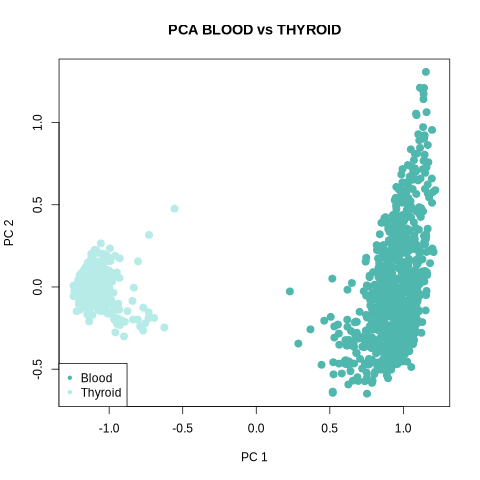

In [25]:
%%R
##### PCA
ranked_path_vals <- path_vals[order(comp$p.value, decreasing = FALSE),]
pca_model <- do_pca(ranked_path_vals[1:ncol(ranked_path_vals),])
pca_plot(pca_model, sample_group_tissue, legend = T, main="PCA BLOOD vs THYROID")
png("data/imagen/pca_bloodvsthyr.png", width = 800, height = 600, res = 100)
pca_plot(pca_model, sample_group_tissue, legend = T, main="PCA BLOOD vs THYROID")
dev.off()

In [46]:
%%R 
sample_group_sub_clean <- factor(gsub(" ", "_", as.character(sample_group_sub)))

# Ver resultado
levels(sample_group_sub_clean)
# Debería ser: "Whole_Blood" y "Thyroid"

colors_de <- node_color_per_de(results, pathways, sample_group_sub_clean,
                                "Whole_Blood", "Thyroid", 
                                colors = "hipathia")

png 
  2 


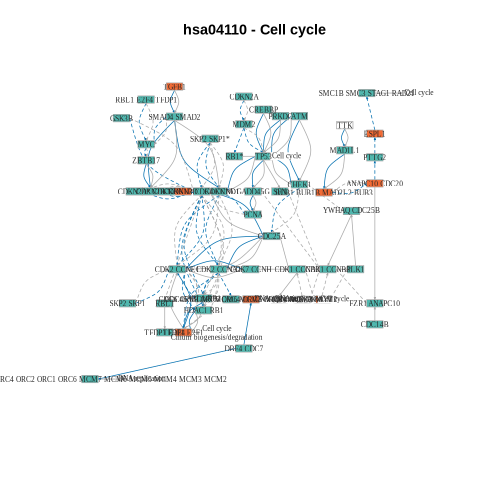

In [57]:
%%R
#colors_de <- node_color_per_de(results, pathways, colors = "hipathia")

pathway_comparison_plot(comp, metaginfo = pathways, pathway = "hsa04110",
                        node_colors = colors_de)
png("data/imagen/comparison_hsa04110.png", width = 800, height = 600, res = 100)
pathway_comparison_plot(comp, metaginfo = pathways, pathway = "hsa04110",
                        node_colors = colors_de)
dev.off()

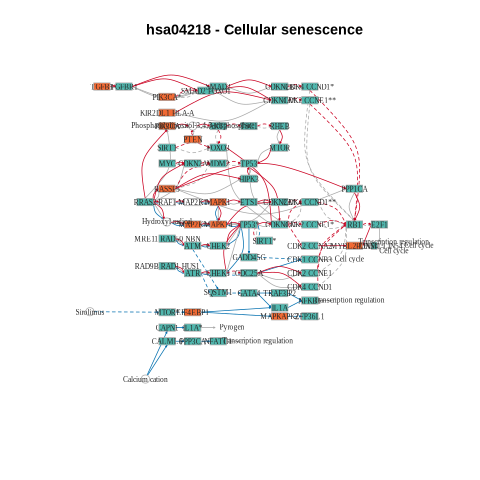

In [52]:
%%R
pathway_comparison_plot(comp, metaginfo = pathways, 
                        pathway = "hsa04218",  # Nota la "P-" al inicio
                       node_colors = colors_de)

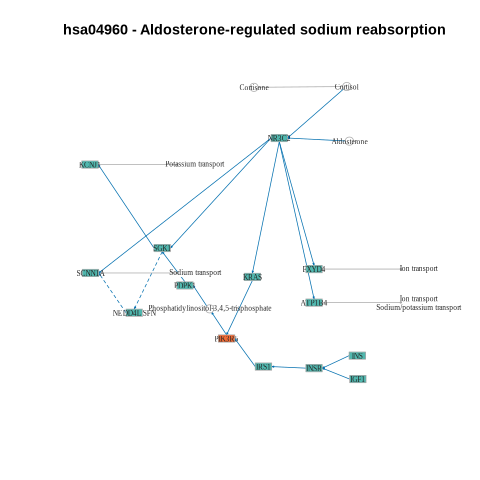

In [53]:
%%R
pathway_comparison_plot(comp, metaginfo = pathways, pathway = "hsa04960",
                        node_colors = colors_de)

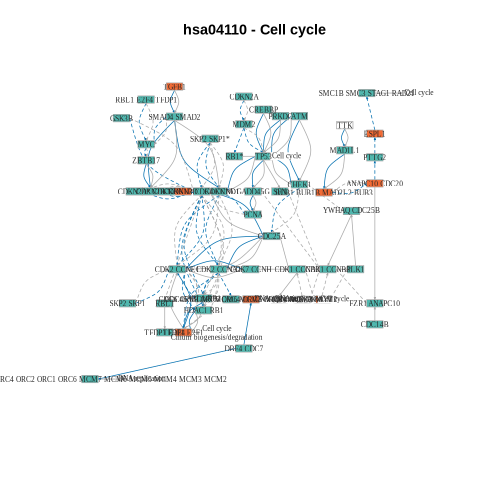

In [54]:
%%R
pathway_comparison_plot(comp, metaginfo = pathways, pathway = "hsa04110",
                        node_colors = colors_de)

In [ ]:
####PARA TRAER LOS DATOS
from pathlib import Path

# Crea la carpeta si no existe
Path("data").mkdir(exist_ok=True)

# Leer archivo desde ruta relativa
import pandas as pd
df = pd.read_csv(Path("data") / "hipathia_output.csv")